# Team Defense of Passing Plays in the 2018 NFL Season

> "Individual commitment to a group effort – that is what makes a team work, a company work, a society work, a civilization work." <br> <p style="text-align:center;">-- Vince Lombardi</p>

### Summary
In Football, defense is played as a *team*, where players on defense work together to stop the offense from progressing the ball further down the field. For this reason, I chose to focus on the team aspect of NFL defenses against passing plays in the 2018 season. Some of my key insights are:

## Collective Team Positioning to Force an Incomplete Pass
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#008bb7;
           font-size:110%;
           letter-spacing:0.5px">

    <p style="padding:15px;color:white;">The Baltimore Ravens and Chicago Bears, two top defensive teams from the 2018 season, were standouts at positioning themselves in such a way to maximize the likelihood of an incompletion both at the moment of pass forward and pass arrived.</p>
</div>

## Collective Team Reaction to Improve Positioning to Force an Incomplete Pass
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#008bb7;
           font-size:110%;
           letter-spacing:0.5px">

    <p style="padding:15px;color:white;">The LA Chargers, Philadelphia Eagles, and SF 49ers were the best teams at reacting to the pass, where they displayed the most improvement in positioning themselves for a likely incompletion between the pass forward and pass arrived moments.</p>
</div>

## Individual Player Impact on Incompletion Likelihood
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#008bb7;
           font-size:110%;
           letter-spacing:0.5px">

    <p style="padding:15px;color:white;">Xavien Howard, Budda Baker, Stephon Gilmore, and Marlon Humphrey are among the top 12 most impactful players driving likely forced incompletions.</p>
</div>

<br>

[1. Overview](#1.-Overview)   
[2. Data Representation](#2.-Data-Representation)  
[3. Method: Pass Outcome Prediction](#3.-Method:-Pass-Outcome-Prediction)   
[4. Team Defense Analysis](#4.-Team-Defense-Analysis)  
[5. Player Defense Analysis](#5.-Player-Defense-Analysis)  
[6. Closing Thoughts](#6.-Closing-Thoughts)  
[7. References](#7.-References)  
[8. Appendix](#8.-Appendix)

# 1. Overview

### Motivation
In any given play, the motion of the defense, reacting to (or anticipating) an offense's movements, may be ideal with everyone in perfect position for a stop. And still, the Wide Receiver may catch, with the tips of his fingers, a perfectly threaded pass from the Quarterback. Alternatively, on a blown coverage, a wide-open Receiver may have the ball slip through his fingers for an incomplete pass. While it is easy to measure a defense's forced incompletion rate from the in-game stats, it is more challenging and also insightful to assess whether a defense was *positioned* well to force the incomplete pass.

### Approach
In this work, I present a versatile framework for analyzing team defenses that enables novel analyses of a team's collective movements, as well as the influence an individual player has on the likelihood of a forced incompletion. Representing player trajectories as pictorial images, I trained Convolutional Neural Networks to predict the outcome of a pass (complete versus incomplete) at different stages of a passing play: ball snap, pass forward, pass arrived, and play end. Using the model predictions, I provide team defense assessments of: 
1. How well **teams collectively position** themselves to force an incompletion.
2. How well **teams collectively react** to the pass forward to position themselves for a likely incompletion by the time of pass arrived.

### Use Cases
These assessments could be leveraged for in-game and post-game analysis of a team's coordinated movement to facilitate in-game adjustments, help tease out areas for improvement, and identify which factors contribute most to forced incompletions.


# 2. Data Representation
Many previous works, e.g., [[3]](https://arxiv.org/abs/1703.03121), [[4]](https://arxiv.org/abs/1706.00893v1), [[5]](https://arxiv.org/abs/1803.07612), that have developed methods for understanding coordinated team movements rely on the $(x,y)$-coordinate representation of the tracking data, where they concatenate all players' trajectories to form the input to a model. 

However, there is not a consistent number of players in each play for the provided 2018 NFL player tracking data. The total number of players ranges from 6 to 22 across all passing plays. To capture the configuration of all provided players for each play, we cannot construct a consistent size matrix of player trajectories across any dimension, including number of players or time. I address this challenge by producing pictorial (image) representations of the tracking data, similar to work of [[1]](https://arxiv.org/abs/1609.04849).

For each play, I generate 4 image representations, one for each of the critical play moments: ball snap, pass forward, pass arrived, and play end. The trajectories always start at the moment of ball snap, and end at each of the critical play moments. To capture the time-dimension of the trajectories, I set a fading factor on the pixel values. Specifically, for a player $p$'s trajectory with $T$ frames, the image pixel value $I(x,y)$ is set as: $$I(x_p^{t},y_p^{t}) = \frac{t}{T} \ \forall \ t \in [1,T]$$ where $(x_p^{t}, y_p^{t})$ is the player's location at frame $t$.

#### Implementation Details
Prior to generating the pictorial image representations, I align all plays to evolve toward the left. I also center the players and ball based on the ball location in the first frame for every play. The offense, defense, and ball trajectories are in the green, red, and blue image channels respectively. Finally, I apply a Gaussian filter with $\sigma=3$ to the images.

The images below show the 4 image representations for a sample play.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import imageio

gameId = 2018120202
playId = 2991
pict_traj_rootdir = '../input/pictorial-trajectories/images/images/'
events = ['ball_snap', 'pass_forward', 'pass_arrived', 'play_end']

font_size = 24

fig = plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(2, 2, width_ratios=[10, 10])
for event_type_i, event_type in enumerate(events):
    im_filename = '{}/{}/{}-{}.png'.format(pict_traj_rootdir, event_type, gameId, playId)
    im = imageio.imread(im_filename)

    ax = plt.subplot(gs[event_type_i]);
    ax.imshow(im);
    plt.title(' '.join([s.capitalize() for s in event_type.split('_')]), fontsize=font_size);
    plt.axis('off');
    
fig_title = 'Pictorial Trajectories for Play Evolution for: Game Id {}, Play Id {}'.format(gameId, playId)
plt.suptitle(fig_title, fontsize=font_size);

# 3. Method: Pass Outcome Prediction

Focusing only on the plays with outcome `pass_complete` or `pass_incomplete`, I train Convolutional Neural Networks with ResNet-18 [[2]](https://arxiv.org/abs/1512.03385) architecture to classify image representations of player trajectories as resulting in either a complete or an incomplete pass. I train one classifier for each play's image representation at the four critical moments of the play: 1) the ball snap, 2) the moment of pass forward, 3) the moment of pass arrived, and 4) the end of the play. Notably, regardless of whether the outcome of a pass was complete or incomplete, the **likelihood of completion** can be estimated. The output of my trained networks provide the likelihood of a pass being complete or incomplete given the ball and player motion for an input play.

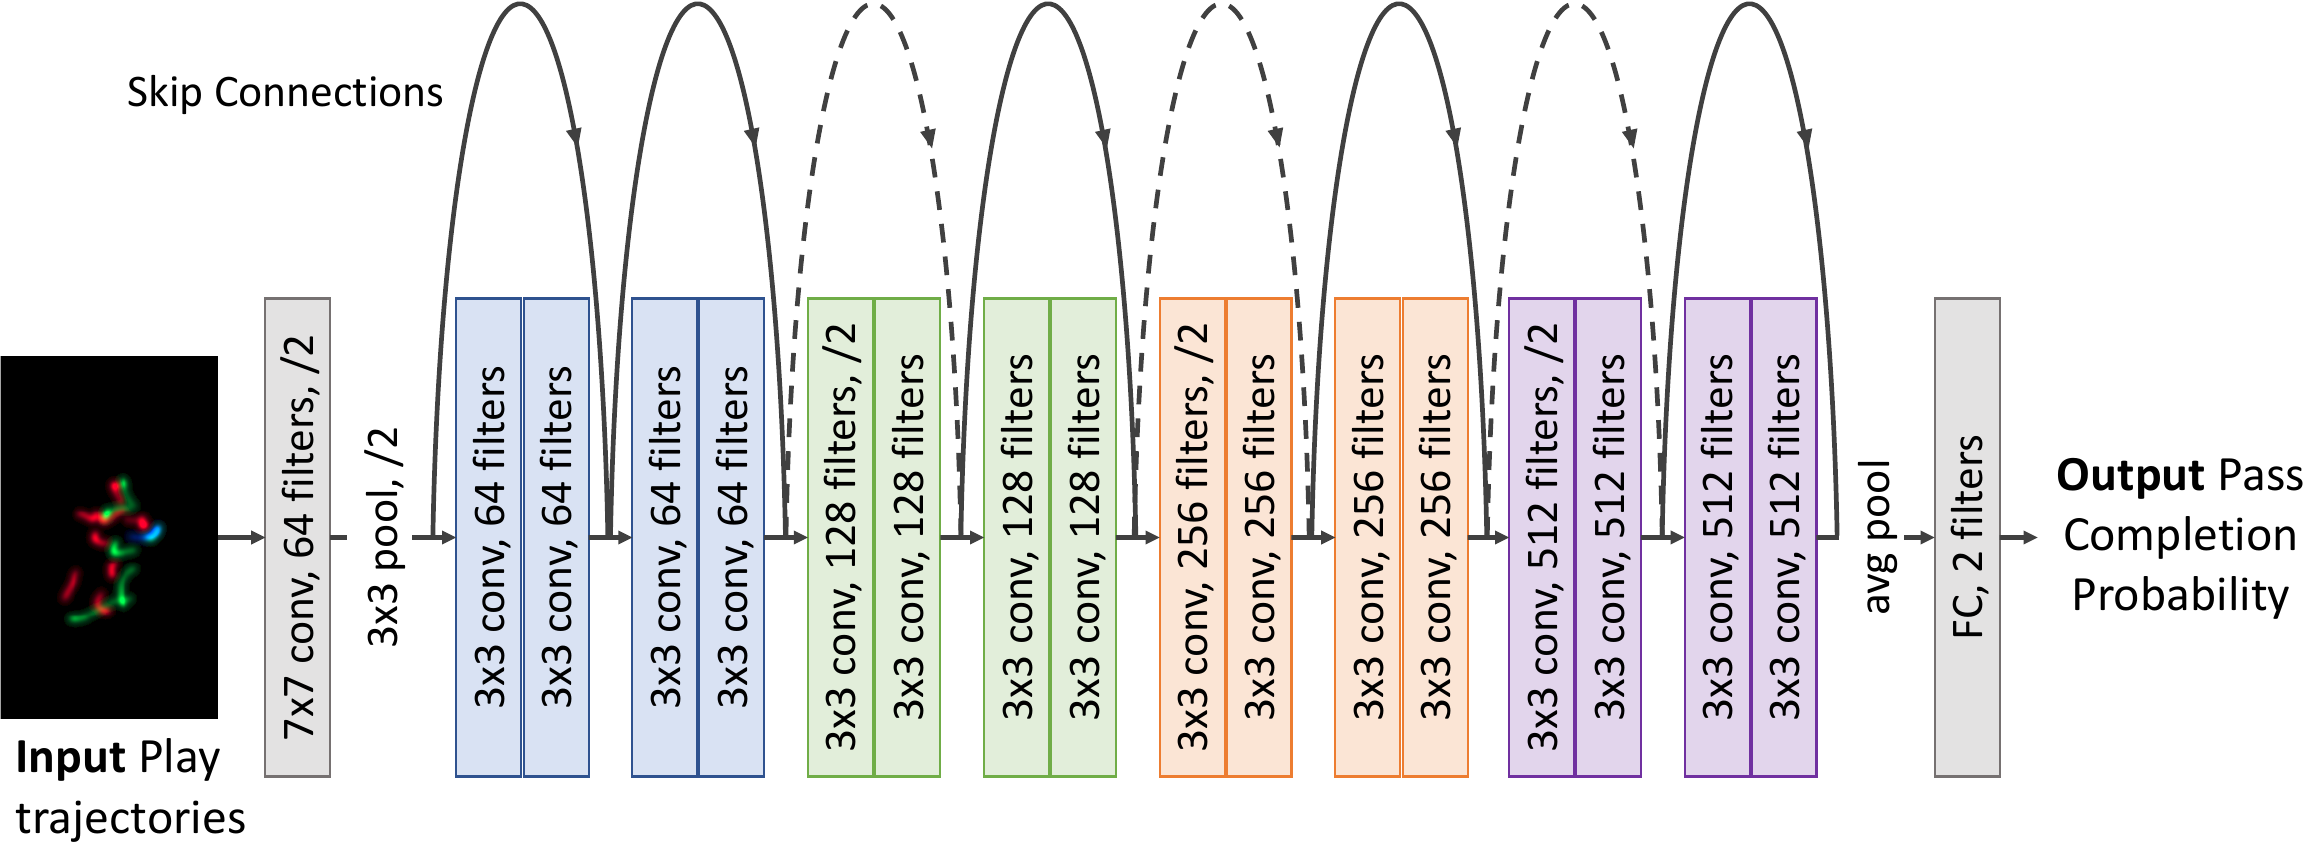

#### Implementation Details
I randomly split games into train, test, and validation splits, and assign all the plays to a game in the same split. The number of plays in each split is: 11721 train, 1663 validation, and 4242 test.

### Model Performance
|**Event**    | **Football** | **Precision** | **Recall** | **F1-Score** | **Accuracy** |
|------------:|:------------:|:-------------:|:----------:|:------------:|:------------:|
|Ball Snap    | Included     | 0.571         | 0.508      | 0.424        | 0.648        |
|Pass Forward | Included     | 0.624         | 0.600      | 0.602        | 0.666        |
|Pass Arrived | Included     | 0.815         | 0.764      | 0.779        | 0.813        |
|Pass Arrived | Ommitted     | 0.684         | 0.664      | 0.670        | 0.714        |
|Play End     | Included     | 0.934         | 0.937      | 0.935        | 0.941        |

Performance of pass outcome prediction models trained at various stages/events of the play.

Among the ~11.7k passing plays in my training dataset, **65%** result in a completion and **35%** result in an incompletion. A model that always predicts completion will be trivially correct 65% of the time. 

The above table shows that the configuration of players at the moment of ball snap does not provide significant signal for predicting the pass outcome (65% accuracy). In other words, there is no silver bullet setup for stopping a pass completion. The player configurations at the moment of pass forward provide a weak signal for predicting pass outcome (67% accuracy). Whereas, there is noticeable signal in the ball and player configurations at the moment of pass arrived to leverage for predicting the pass result (81% accuracy). At the moment the pass arrives, the proximity of the ball to a receiver may be sufficiently suggestive of whether a pass will be complete or incomplete. Removing the football trajectory from the input image shows there is signal in the player configurations alone (71% accuracy).

The best possible prediction performance with pictorial image representations should be (and is) achieved when including the full play. The movement of a receiver with the ball and a ball that lands in no man's land are both strong indications of outcome. The performance of this model (94% accuracy) provides an estimate for the performance upper bound for using pictorial image representations of player motion to predict pass outcome. 

There is certainly room for improvement in these models. Nevertheless, assessing the (relative to league average) per-team average incompletion likelihoods estimated by these models is insightful.

# 4. Team Defense Analysis

Using these network predictions, I assess how team defenses compare to league average at positioning themselves in such a way to force an incomplete pass. I compute the per-team incompletion likelihood comparison: ball snap, pass forward, and pass arrived. At each critical moment of play, this captures how well (relative to league average) **each defensive team is configured** to force an incompletion.

I also compute the per-team average improvement in incompletion likelihood from the moment of pass forward to the moment of pass arrived, again relative to the league average. This measures how well **each defensive team reacts** to where the ball is actually going. 

In both cases, positive scores indicate a team peformed better than league average.

The figure below shows these per-team comparisons relative to league average. With additional context of the actual per-team pass incompletion percentage relative to league average, some interesting team insights emerge:

1. The **Baltimore Ravens** and **Chicago Bears**, two top defensive teams from the 2018 season, were standouts at positioning themselves in such a way to maximize the likelihood of an incompletion both at the moment of pass forward and pass arrived. Notably, the Baltimore Ravens have the highest forced incompletion percentage of any team in 2018.
2. The **LA Chargers**, **Philadelphia Eagles**, and **SF 49ers** were the best teams at reacting to the pass, where they displayed the most improvement in positioning themselves for a likely incompletion between the pass forward and pass arrived moments.
3. The **Indiana Colts** and **Tampa Bay Buccaneers** have the worst forced incompletion rates, and both teams' positioning is noticeably worse than league average at all three critical play moments.
4. The **Dallas Cowboys** position themselves well by time of the moment of pass arrived, and yet they have a forced incompletion rate more consistent with teams who position themselves worse than league average by the moment of pass arrived, e.g., **Arizona Cardinals**, **Atlanta Falcons**, **Carolina Panthers**, and **Cincinnati Bengals**.
5. The **New England Patriots**, **Oakland Raiders**, and **Pittsburgh Steelers** have the worst improvement in positioning from the moment of pass forward to the moment of pass arrived. Yet, all three teams have higher than league average forced incompletion rates.

In [ ]:
### pass outcome prediction team defense analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import utils

data_rootdir = '../input/nfl-big-data-bowl-2021/'
pass_pred_rootdir = '../input/pass-outcome-predictions/'

df_games = utils.load_csv(data_rootdir, 'games.csv')
df_plays = utils.load_csv(data_rootdir, 'plays.csv')

df_plays_teams = pd.merge(df_plays, df_games, how="left", on=["gameId"])
# get the team on defense
df_plays_teams['defenseTeam'] = df_plays_teams.apply(lambda x: \
                                   x['homeTeamAbbr'] if x['visitorTeamAbbr'] \
                                   == x['possessionTeam'] else x['visitorTeamAbbr'], axis=1)

event_types = ['ball_snap', 'pass_forward', 'pass_arrived', 'play_end']

df_ball_snap = utils.load_csv(pass_pred_rootdir,'{}.csv'.format('ball_snap'))
df_pass_forward = utils.load_csv(pass_pred_rootdir,'{}.csv'.format('pass_forward'))
df_pass_arrived = utils.load_csv(pass_pred_rootdir,'{}.csv'.format('pass_arrived'))

df_pass_forward = pd.merge(df_pass_forward, df_plays_teams, how="left", on=["gameId", "playId", "passResult"])
df_pass_arrived = pd.merge(df_pass_arrived, df_plays_teams, how="left", on=["gameId", "playId", "passResult"])
df_ball_snap = pd.merge(df_ball_snap, df_plays_teams, how="left", on=["gameId", "playId", "passResult"])

merge_keys = ['passResult', 'gameId', 'playId','playDescription', 'quarter', 'down',
              'yardsToGo', 'possessionTeam', 'playType', 'yardlineSide',
              'yardlineNumber', 'offenseFormation', 'personnelO', 'defendersInTheBox',
              'numberOfPassRushers', 'personnelD', 'typeDropback',
              'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
              'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
              'offensePlayResult', 'playResult', 'epa', 'isDefensivePI', 'gameDate',
              'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr', 'week', 'defenseTeam']

df = pd.merge(df_ball_snap, df_pass_arrived, how="inner", on=merge_keys)
df = pd.merge(df, df_pass_forward, how="inner", on=merge_keys)


# pass_forward_mean = df[['p_Incomplete pass_forward', 'defenseTeam']].groupby('defenseTeam').describe()['p_Incomplete pass_forward']['mean']
# pass_forward_mean = pass_forward_mean - np.mean(pass_forward_mean)



# ipdb.set_trace()

# possession_team = util.get_slice_by_id(df_plays, playId, gameId)['possessionTeam']

# offense, defense = util.get_offense_defense()

def get_metric(df, event_type):
    if len(event_type) == 1:
        event_type = event_type[0]
    else:
        df['p_Incomplete {}_minus_{}'.format(event_type[0], event_type[1])] = df['p_Incomplete {}'.format(event_type[0])] - df['p_Incomplete {}'.format(event_type[1])]
        event_type = '{}_minus_{}'.format(event_type[0], event_type[1])
    metric_mean = df[['p_Incomplete {}'.format(event_type), 'defenseTeam']].groupby('defenseTeam').describe()['p_Incomplete {}'.format(event_type)]['mean']
    metric_mean = metric_mean - np.mean(metric_mean)
        
    df_metric_mean = pd.DataFrame.from_dict({'defenseTeam': metric_mean.index.tolist(), event_type: metric_mean.values.tolist()})
    
    return metric_mean, df_metric_mean
                          
ball_snap_metric, df_ball_snap_metric = get_metric(df, ['ball_snap'])
pass_forward_metric, df_pass_forward_metric = get_metric(df, ['pass_forward'])
pass_arrived_metric, df_pass_arrived_metric = get_metric(df, ['pass_arrived'])
pass_difference_metric, df_pass_difference_metric = get_metric(df, ['pass_arrived', 'pass_forward'])

temp = df_plays_teams[df_plays_teams['passResult'].isin(['C', 'I'])].groupby('defenseTeam')['passResult'].value_counts(normalize=True)
df_incomplete_metric = temp[:, 'I'] #.sort_values(ascending=False)
df_incompletion_rate = pd.DataFrame.from_dict({'defenseTeam': df_incomplete_metric.index.tolist(), 'incompletionRate': df_incomplete_metric.values.tolist()})
df_incompletion_rate['incompletionRate'] = df_incompletion_rate['incompletionRate'] - np.mean(df_incompletion_rate['incompletionRate'])
df_incomplete_metric = df_incomplete_metric - np.mean(df_incomplete_metric)

# temp = pd.merge(df_ball_snap_metric, df_incompletion_rate, how='inner', on=['defenseTeam'])
# temp = pd.merge(temp, df_pass_forward_metric, how='inner', on=['defenseTeam'])
# temp = pd.merge(temp, df_pass_arrived_metric, how='inner', on=['defenseTeam'])
# temp = pd.merge(temp, df_pass_difference_metric, how='inner', on=['defenseTeam'])
# temp.sort_values('incompletionRate', ascending=False)

def add_value_labels(ax, x_labels, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for i, rect in enumerate(ax.patches):
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        
        if x_labels[i] not in ['LAC', 'PHI', 'SF']:
            rect.set_color('gray')
        if x_labels[i] in ['BAL', 'CHI']:
            rect.set_color('limegreen')
        if x_labels[i] in ['IND', 'TB']:
            rect.set_color('darkred')
        if x_labels[i] in ['OAK', 'NE', 'PIT']:
            rect.set_color('darkorange')
        if x_labels[i] in ['DAL']:
            rect.set_color('dimgray')

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            x_labels[i],                # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,                      # Vertically align label differently for
            fontsize=18)                # positive and negative values.


def add_line(ax, y_coord):
    line = Line2D([-1,32],[y_coord,y_coord], color='lightgray')
    ax.add_line(line)
    ax.annotate(y_coord, (31.25, y_coord+0.005), ha='right', fontsize=14, color='gray')
    ax.annotate(y_coord, (-0.25, y_coord+0.005), ha='left', fontsize=14, color='gray')


def plot_metric_bars(metric, plot_title):
    x_labels = metric.index

    # Plot the figure.
    plt.figure(figsize=(26, 8))
    plt.ylim([-0.125,0.125])
    plt.axis('off')
    ax = metric.plot(kind='bar', zorder=100)
    ax.set_title(plot_title,fontsize=24)
    #ax.set_ylabel('')
    #ax.set_xticklabels(x_labels)
    ax.set_xticks([])
    ax.set_yticks([])
    
    for y_c in [-0.1, -0.05, 0.05, 0.1]:
        add_line(ax, y_c)
    
    add_value_labels(ax, x_labels)


plot_metric_bars(df_incomplete_metric, r"$\bf{At \ Pass \ Result}$" + ' Team Defense Raw Forced Incompletion Percentage Relative to Average Team')
plot_metric_bars(ball_snap_metric, r"$\bf{At \ Ball \ Snap}$" + ' Team Defense Average Incompletion Likelihood Relative to Leauge Average')
plot_metric_bars(pass_forward_metric, r"$\bf{At \ Pass \ Forward}$" + ' Team Defense Average Incompletion Likelihood Relative to Leauge Average')
plot_metric_bars(pass_arrived_metric, r"$\bf{At \ Pass \ Arrived}$" + ' Team Defense Average Incompletion Likelihood Relative to League Average')
plot_metric_bars(pass_difference_metric, r"$\bf{Improvement \ from \ Pass \ Forward \ to \ Pass \ Arrived}$" + ' Team Defense Average Incompletion Likelihood Relative to League Average')

## Why was an incompletion likely or unlikely on a given play? 

Using class activation heatmaps [[6]](https://arxiv.org/abs/1512.04150), I am able to identify which parts of a play the model is using for its prediction. In other words, these maps can help identify why an incompletion was likely (or unlikely) for any given play. 

Naturally, there can be very obvious likely incompletions at the moment of "pass arrived." The example below shows one such example; a pass to no man's land thrown by Jared Goff. The class activation map shows the model is relying on the "right" region of the image to make the correct pass outcome prediction.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import pandas as pd
import utils

class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
    def remove(self): 
        self.hook.remove()
        
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

def plot_class_activation_maps(gameId, playId):
    
    df_pass_outcome_prediction = pd.read_csv('../input/pass-outcome-predictions/pass_arrived.csv')
    class_labels = ['Completion', 'Incompletion']

    normalize = transforms.Normalize(
       mean = [0.8278661085744993, 0.6397270091149045, 0.21311753731973818],
       std = [8.311023923412382, 6.806565451355073, 4.151762584107889]

    )

    preprocess = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       normalize
    ])

    display_transform = transforms.Compose([
       transforms.Resize((370,660))])
    display_transform_tensor = transforms.Compose([
       transforms.Resize((370,660)),
       transforms.ToTensor()])

    
    fig = plt.figure(figsize=(26,20))
    plt.subplot(1,2,1);
    impath = '../input/pictorial-trajectories/images/images/pass_arrived/{}-{:04d}.png'.format(gameId, playId)
    image = Image.open(impath)
    imshow(image)
    plt.axis('off');
    plt.xlim((80,660-80));
    plt.ylim((370-20,20));
    pass_result = utils.get_slice_by_id(df_pass_outcome_prediction, playId, gameId)['passResult'].values[0]
    outcome = {'I': 'Incompletion', 'C': 'Completion'}
    plt.title(r"$\bf{Image \ Trajectory}$" + ' Game Id {}, Play Id {}, Outcome: {}\n Red: Defense, Green: Offense, Blue: Football'.format(gameId, playId, outcome[pass_result]), fontsize=20)
    #plt.savefig('{}-{:04d}_pass_arrived.png'.format(gameId, playId))

    tensor = preprocess(image)

    #prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
    prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)

    model = models.resnet18().eval()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    #model.load_state_dict(torch.load('../input/pass-outcome-models/pass_arrived.ckpt'))
    model.load_state_dict(torch.load('../input/pass-outcome-models/pass_arrived.ckpt', map_location=torch.device('cpu')))

    #model.cuda()
    #model.eval()

    final_layer = model._modules.get('layer4')

    activated_features = SaveFeatures(final_layer)

    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction,dim=1).data.squeeze()
    activated_features.remove()

    topk(pred_probabilities,1)

    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

    class_idx = topk(pred_probabilities,1)[1].int()
    
    overlay = getCAM(activated_features.features, weight_softmax, class_idx )

    plt.subplot(1,2,2);
    imshow(display_transform(image));
    imshow(skimage.transform.resize(overlay[0], display_transform_tensor(image).shape[1:3]), alpha=0.5, cmap='jet');
    plt.axis('off');
    plt.xlim((80,660-80));
    plt.ylim((370-20,20));
    probability = np.max(utils.get_slice_by_id(df_pass_outcome_prediction, playId, gameId)[['p_Complete pass_arrived', 'p_Incomplete pass_arrived']].values)
    plt.title(r"$\bf{Class \ Activation \ Map}$" + '\nProbability of {} is {:02.2f}'.format(class_labels[class_idx], probability), fontsize=20);

#zip([2018111110, 2018123009, 2018091607, 2018102802], [969, 1271, 125, 2260])

plot_class_activation_maps(2018111110, 969)

Similarly, there are clear cases where the ball is thrown to a noticeably open receiver. For example, in the below play, Jeff Driskel finds an open Auden Tate for a likely completion. Here, my model correctly predicts the completion, using the cluster of ball and player trajectories nearer to the receiver.

In [ ]:
plot_class_activation_maps(2018123009, 1271)

In one final example, Deshaun Watson attempts a riskier pass to a closely covered DeAndre Hopkins. Here, my model extremely narrowly correctly predicts an incompletion. Interestingly, sometimes the most salient part of the play for the model prediction is not where the players are, but rather, where they are not. 

In [ ]:
plot_class_activation_maps(2018091607, 125)

# 5. Player Defense Analysis

**A major advantage of my approach is that it seamlessly handles any number of missing players trajectories, affording flexibility in which players are analyzed.** As a result, I can remove a player $p$'s trajectory in the pictorial representation, and re-run my pass outcome prediction model on the revised image to get a new estimate of completion likelihood. The difference between this player-removed completion likelihood and the original estimate derived from using all the players trajectories quantifies the **direct** impact player $p$ has on his team's likelihood of forced incompletion.

In the example images below, the slider indicates which player's trajectory was removed, along with the corresponding player-removed completion likelihood. Comparing with each player-removed completion likelihood shows how critical Xavien Howard was individually to this incompletion. Without him, the play had a 99% chance of being a *completion* compared to 38% chance with him. Hence, an additional use-case of this could be to help quickly retrieve plays where a particular defender was the sole coverage defender on a pass.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import plotly.express as px
from skimage import io
import pandas as pd
import numpy as np
import imageio
import utils

df_player = pd.read_csv('../input/pass-outcome-predictions/pass_arrived_pass_result_prob_PLAYER_full.csv')
df_team = pd.read_csv('../input/pass-outcome-predictions/pass_arrived.csv')
df_player_list = pd.read_csv('../input/nfl-big-data-bowl-2021/players.csv')


gameId = 2018100702
playId = 3173
pict_traj_rootdir = '../input/pictorial-trajectories-player-removed-subset/'
#nflIds = ['2539309', '2539935', '2555539', '2558070', '2559053', '2560966', '496739']
nflIds = utils.get_slice_by_id(df_player, playId, gameId)['nflId'].values.tolist()
p_complete = utils.get_slice_by_id(df_player, playId, gameId)['p_Complete pass_arrived player'].values.tolist()
nflIds_pC_combined = ['{}, P(C)={:02.02f}'.format(nflId, p) for nflId,p in zip(nflIds, p_complete)]

displayNames = [df_player_list[df_player_list['nflId']==nflId]['displayName'].values[0] for nflId in nflIds]
displayNames_pC_combined = ['{}, P(C)={:02.02f}'.format(displayName, p) for displayName,p in zip(displayNames, p_complete)]


# font_size = 24

# fig = plt.figure(figsize=(20,12))
# gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 10, 10])
images = np.zeros((7,370, 660, 3))
for player_i, nflId in enumerate(nflIds):
    im_filename = '{}/{}-{}_{}.png'.format(pict_traj_rootdir, gameId, playId, nflId)
    im = imageio.imread(im_filename)
    images[player_i] = im
    

#from skimage.data import image_fetcher
#path = image_fetcher.fetch('data/cells.tif')
#data = io.imread(path)
#img = data[25:40]
full_play_p_complete = utils.get_slice_by_id(df_team, playId, gameId)['p_Complete pass_arrived'].values[0]
fig = px.imshow(images[:,50:370-50,140:660-100,:], animation_frame=0, binary_string=True, labels={'animation_frame':"Player"});
fig.update_xaxes(showticklabels=False);
fig.update_yaxes(showticklabels=False);
fig.update_layout(
    title={
        'text': "Image Representations of Play with Removing One Player's<br>Trajectory at a Time, and Predicting Likelihood of Completion, P(C)<br><br>Original Play:<br>P(C)={:02.02f}".format(full_play_p_complete),
    });
steps = []
for i in range(7):
    step = {
        'label': displayNames_pC_combined[i]
    }
    #step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict(
    active=10,
    pad={"t": 50},
    steps=steps
)]

# slider_step = {'args': [
#         [year],
#         {'frame': {'duration': 300, 'redraw': False},
#          'mode': 'immediate',
#        'transition': {'duration': 300}}
#      ],
#      'label': year,
#      'method': 'animate'}
#     sliders_dict['steps'].append(slider_step)

fig.update_layout(
    sliders=sliders
);

fig.show();

#     ax = plt.subplot(gs[player_i]);
#     ax.imshow(im);
#     #plt.title(' '.join([s.capitalize() for s in event_type.split('_')]), fontsize=font_size);
#     plt.title(nflId);
#     plt.axis('off');
    
# fig_title = 'Pictorial Trajectories at Pass Arrived, Removing One Player at a Time'.format(gameId, playId)
# plt.suptitle(fig_title, fontsize=font_size);

Focusing only on plays that resulted in an incompletion, I compute the average player (direct) impact as the average increase in completion likelihood when that player's trajectory is removed. The table below shows the top 12 players in the league ranked by this estimated Average Impact, computed based on trajectories up to the moment of pass arrived. For a fair comparison, results are only shown on the plays in the test split, i.e., the plays that were not seen during model training. In order to reasonably estimate the true Average Impact for a full season, models would need to be trained on data from a different season.

In [ ]:
import pandas as pd
import numpy as np

df_player = pd.read_csv('../input/pass-outcome-predictions/pass_arrived_pass_result_prob_PLAYER_full.csv')
df_team = pd.read_csv('../input/pass-outcome-predictions/pass_arrived.csv')
df_player_list = pd.read_csv('../input/nfl-big-data-bowl-2021/players.csv')

df = pd.merge(df_player, df_team, how='left', on=['gameId', 'playId', 'passResult'])
df = pd.merge(df, df_player_list, how='left', on=['nflId'])

df_game_play = df[['gameId','playId']].groupby(['gameId','playId']) \
                                      .size() \
                                      .reset_index()[['gameId', 'playId']]

df['p_Complete delta'] = df['p_Complete pass_arrived player'] - df['p_Complete pass_arrived']
df['p_Complete delta v league average'] = df['p_Complete delta'] - np.mean(df['p_Complete delta'])

#players_to_include = df['displayName'].value_counts().index[df['displayName'].value_counts().values>=50].values.tolist()
#
##ipdb.set_trace()
#df = df[df['displayName'].isin(players_to_include)]


df = df[df['passResult'].isin(['I'])]

players_to_include = df['displayName'].value_counts().index[df['displayName'].value_counts().values>30].values.tolist()
#ipdb.set_trace()
df = df[df['displayName'].isin(players_to_include)]

df_delta_by_player = df[['nflId','p_Complete delta','p_Complete delta v league average','displayName', 'position']].groupby(['nflId','displayName', 'position']).describe() 

df_stats = df_delta_by_player['p_Complete delta'][['mean','count', 'std']]
#df_stats = df_stats[df_stats['count']>=50]

pd.options.display.max_rows = 999
df_sorted = df_stats.sort_values('mean',ascending=False)

#.sort_values(by='mean',ascending=False)

#df_player_stats = pd.merge(df_delta_by_player, df_player_list[['nflId','displayName']], on=['nflId'])



df_stats_top = df_sorted.reset_index()[['nflId', 'displayName', 'position', 'mean', 'count']].head(12)
df_stats_top['Number of Plays'] = df_stats_top['count'].astype('int')
df_stats_top['Average Impact'] = df_stats_top['mean']
df_stats_top['Player Name'] = df_stats_top['displayName']
df_stats_top['Position'] = df_stats_top['position']
df_stats_top['Rank'] = list(range(1,13))
df_stats_top[['Rank','Player Name', 'Position', 'Average Impact', 'Number of Plays']].style.hide_index()


Many of the players I identify as high impact players with this analysis *are* known to be high impact players. At number 1, Xavien Howard is known to be a league-leading defender in interceptions. The versatile Budda Baker is the only non-Cornerback in the top 12 list. At number 4, Stephon Gilmore has arguably been one of the best Cornerbacks in the league for some time, averaging 12.7 pass deflections per season. At number 9, Malcom Bulter has averaged 11.7 pass deflections per season in 7 seasons. In 2018, Marlon Humphrey (ranked number 12) had 15 pass deflections and 2 interceptions. 

# 6. Closing Thoughts

The team positioning and trajectory motion only tells part of a team's defensive story on a play. There are many contributing factors to forcing an incompletion. For example, compared to player pose, a player's 2D trajectory on the field is a coarse measurement of the player's positioning. Hence, even when a player is in the correct location on the field, they may not be in the right pose to successfully interfere with a pass. Furthermore, two different players, of two different heights, lengths, speeds, reaction times, aggressiveness, etc. may have two different pass outcomes even when positioned in the exact same place on the field.

That said, a team positioning itself well to force an incompletion is an important aspect of team defense. In this work, I've introduced a method for measuring a team's defense positioning that can be applied to plays with any number of players' trajectories available, without relying on hand-crafted features. Moreover, a team reacting well to get into position to force an incompletion is also a desirable quality in a defensive team. As I've shown, a simple extension of my method enables a team's collective pass-reaction to be quantified, and individual players' impacts on the incompletion likelihood to be quantified.

# 7. References

[1] Harmon, Mark, et al. "Predicting shot making in basketball learnt from adversarial multiagent trajectories." arXiv preprint arXiv:1609.04849 (2016). [paper link](https://arxiv.org/abs/1609.04849)

[2] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016. [paper link](https://arxiv.org/abs/1512.03385)

[3] Le, Hoang M., et al. "Coordinated multi-agent imitation learning." arXiv preprint arXiv:1703.03121 (2017). [paper link](https://arxiv.org/abs/1703.03121)

[4] Mehrasa, Nazanin, et al. "Learning person trajectory representations for team activity analysis." arXiv preprint arXiv:1706.00893 (2017). [paper link](https://arxiv.org/abs/1706.00893v1)

[5] Zhan, Eric, et al. "Generating multi-agent trajectories using programmatic weak supervision." arXiv preprint arXiv:1803.07612 (2018). [paper link](https://arxiv.org/abs/1803.07612)

[6] Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016. [paper link](https://arxiv.org/abs/1512.04150)

# 8. Appendix

Full code, including training and evaluation code is available at this [Github repo](https://github.com/pannaf/nfl2021-big-data-bowl). 

Also, if running in the notebook is desired, evaluation code is included in the hidden cell below.

In [ ]:
### dataloader
import matplotlib.pyplot as plt
from dataloader import PlayDataset

unit_test = False

def unit_test_load_all_data(split=None, event_type=None):
    if split is None:
        split = 'train'
    if event_type is None:
        event_type = 'pass_arrived'
    im_rootdir = '../input/pictorial-trajectories/images/images/{}'.format(event_type)
    data_rootdir = '../input/nfl-big-data-bowl-2021/'
    split_files_rootdir = '../input/pictorial-trajectories/data_splits/'
    data = PlayDataset(split, im_rootdir, data_rootdir, split_files_rootdir)
    return data

# set unit_test to True to run this
if unit_test:
    data = unit_test_load_all_data('train', 'pass_forward')

    # this is for debugging purposes
    plt.imshow(data[0][0]);
    
## run this to create pictorial image representations
## note that these take a while to generate, so I loaded the pictorial image
## representations as a dataset, which I'm storing in input/pictorial-trajectories

import create_pictorial_trajectories
import os

generate_pictorial_trajectories = False
## generate the pictorial trajectory representations by calling this on all event types and all weeks:
if generate_pictorial_trajectories:
    create_pictorial_trajectories.generate_pictorial_trajectories(['ball_snap', 'pass_forward', 'pass_arrived', 'play_end'], range(1,18))
## testing the functionality in this notebook..
#os.system('mkdir -p ./pictorial_trajectories/pass_arrived')
#os.system('rm -r pictorial_trajectories')
#create_pictorial_trajectories.generate_pictorial_trajectories(['ball_snap'], [1])

### evaluation code for pass outcome predictor

import torch
import pandas as pd
import torch.nn as nn
from torch.utils import data
#from motion_models.dataloader_team_analysis import PlayDataset
import numpy as np
from skimage import io, transform
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from PIL import Image


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters for data loader
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2 
          }
params_eval = {'batch_size': 64,
               'shuffle': False,
               'num_workers': 2 
               }

## Note: to run this for different play moments, change the event_type
## valid event types are: 'ball_snap', 'pass_forward', 'pass_arrived', 'play_end'
## to get the result for the pass_arrived_no_ball model, set mean = 0, std = 1 for the 3rd
## channel in the normalization and set the value of the football channel to all zeros
## in the dataloader
event_type = 'pass_arrived' 
im_size = 224
evaluate_pass_outcome = False

im_rootdir = '../input/pictorial-trajectories/images/images/{}'.format(event_type)
data_rootdir = '../input/nfl-big-data-bowl-2021/'
split_files_rootdir = '../input/pictorial-trajectories/data_splits/'

def evaluate(dataloader, model, event_type):
    with torch.no_grad():
        softmax = nn.Softmax(dim=1)
        correct = 0
        total = 0
        predicted_list = []
        groundtruth_list = []

        passResult = []
        gameIds = []
        playIds = []
        probCom = []
        probInc = []
        label_map = ['C', 'I']

        for (local_batch,local_labels,local_games,local_plays) in dataloader:
            # Transfer to GPU
            local_ims, local_labels = local_batch.to(device), local_labels.to(device)

            outputs = model(local_ims)
            probability = softmax(outputs)
            
            passResult.extend([label_map[pr] for pr in local_labels.cpu().numpy().tolist()])
            gameIds.extend(local_games.cpu().numpy().tolist())
            playIds.extend(local_plays.cpu().numpy().tolist())
            probCom.extend(probability[:,0].cpu().numpy().tolist())
            probInc.extend(probability[:,1].cpu().numpy().tolist())

            _, predicted = torch.max(outputs.data, 1)
            total += local_labels.size(0)
            predicted_list.extend(predicted)
            groundtruth_list.extend(local_labels)
            correct += (predicted == local_labels).sum().item()
            #ipdb.set_trace()

        print('Accuracy of the network on the {} evaluation images: {} %'.format(total, 100 * correct / total))
    pl = [p.cpu().numpy().tolist() for p in predicted_list]
    gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

    from sklearn.metrics import classification_report
    print(classification_report(gt, pl, digits=3))

    for id in range(len(label_map)):
        print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

    results_df = {'passResult': passResult,
                  'gameId': gameIds,
                  'playId': playIds,
                  'p_Complete {}'.format(event_type): probCom,
                  'p_Incomplete {}'.format(event_type): probInc
                 }
    results_df = pd.DataFrame.from_dict(results_df)
    return results_df

## Pre-computed mean and std based on training data
if event_type is 'ball_snap':
    mean = [0.22185783632826273, 0.17329253537644185, 0.05810781520547683]
    std = [3.8430682508407914, 3.525189335135875, 2.733388403720904]

## pass forward
if event_type is 'pass_forward':
    mean = [0.5154701721714169, 0.42373869342749004, 0.11667604609513321]
    std = [5.975045342280524, 5.114765323946453, 3.689086707138345]

if event_type is 'pass_arrived':
    mean = [0.8278661085744993, 0.6397270091149045, 0.21311753731973818]
    std = [8.311023923412382, 6.806565451355073, 4.151762584107889]

if event_type is 'play_end':
    mean = [1.038661048777042, 0.747664668936503, 0.27118879995517553]
    std = [8.973929529255928, 7.132237691495664, 4.781272060488431]

# Generators
train_dataset = PlayDataset('train',im_rootdir, data_rootdir, split_files_rootdir,
                                    transform=transforms.Compose([
                                               transforms.RandomVerticalFlip(),
                                               transforms.Resize((im_size, im_size)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
train_loader = data.DataLoader(train_dataset, **params)

dev_dataset = PlayDataset('dev',im_rootdir, data_rootdir, split_files_rootdir,
                                transform=transforms.Compose([
                                           transforms.Resize((im_size, im_size)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean, std)
                                       ]))

dev_loader = data.DataLoader(dev_dataset, **params_eval)
test_dataset = PlayDataset('test',im_rootdir, data_rootdir, split_files_rootdir,
                                transform=transforms.Compose([
                                           transforms.Resize((im_size, im_size)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean, std)
                                       ]))

test_loader = data.DataLoader(test_dataset, **params_eval)

alexnet = False
if alexnet:
    model_conv = models.alexnet() #pretrained='imagenet')
    num_ftrs = model_conv.classifier[6].in_features
    # convert all the layers to list and remove the last one
    features = list(model_conv.classifier.children())[:-1]
    ## Add the last layer based on the num of classes in our dataset
    n_class = 3 
    features.extend([nn.Linear(num_ftrs, n_class)])
    ## convert it into container and add it to our model class.
    model_conv.classifier = nn.Sequential(*features)
else:
    print('Using ResNet-18 model')
    model_conv = models.resnet18()
    num_ftrs = model_conv.fc.in_features
    n_class = 2 
    model_conv.fc = nn.Linear(num_ftrs, n_class)

model = model_conv.to(device)
if not use_cuda:
    model.load_state_dict(torch.load('../input/pass-outcome-models/{}.ckpt'.format(event_type), map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('../input/pass-outcome-models/{}.ckpt'.format(event_type)))

if evaluate_pass_outcome:
    print('Development set evaluation')
    evaluate(dev_loader, model, event_type) 
    print('Test set evaluation')
    results_df = evaluate(test_loader, model, event_type) 
    #results_df.to_csv('{}_pass_result_probabilities.csv'.format(event_type), index=False)

